# **Install Packages**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qiskit
from qiskit import Aer
from qiskit.opflow import PauliTrotterEvolution, StateFn, PauliExpectation
from qiskit.opflow import CircuitSampler, PauliOp, MatrixEvolution, Suzuki
from qiskit.opflow import I, X, Y, Z, Zero, One, Plus, Minus, CX, CZ, Swap
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit, Aer, assemble, QuantumRegister, IBMQ, execute, transpile
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.extensions import HamiltonianGate
from qiskit.visualization import plot_histogram, plot_bloch_multivector
import random
from qiskit.tools.visualization import circuit_drawer
import warnings
import math
from numba import jit
warnings.filterwarnings('ignore')



/tmp/ipykernel_1372/453760317.py:5: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  from qiskit.opflow import PauliTrotterEvolution, StateFn, PauliExpectation


In [2]:
plt.rcParams["figure.figsize"] = (20,10)

# **1 Qubit**

In [ ]:
def qubit_1(psi,g,delta_t,delta_x,V0,V1,n,N,color):
  gamma = 1/(2*delta_x**2)
  L = X
  U = (-1*gamma*L*delta_t).exp_i() #u.exp_i() returns e^(-iu)
  U = Operator(U)
  psi0_2,psi1_2 = psi[0]**2,psi[1]**2
  prob0 = [psi0_2]

  #step 1
  qc = QuantumCircuit(1)
  qc.initialize(psi,0)
  qc.append(U,[0])

  #step 2
  qc.measure_all()

  #step 3
  backend_sim = Aer.get_backend('qasm_simulator')
  job_sim = backend_sim.run(transpile(qc, backend_sim), shots=N)
  result_sim = job_sim.result()
  counts = result_sim.get_counts(qc)
  #print(counts)
  if '0' in counts:
    psi0_2 = counts['0']/N
  else:
    psi0_2 = 0
  if '1' in counts:
    psi1_2 = counts['1']/N
  else:
    psi1_2 = 0

  j = 0 #step 4
  V = []
  
  for j in range(n): #step 5&10
    qc = QuantumCircuit(1)
    qc.initialize(psi,0)
    
    #step 6
    
    V.append(Operator([[np.exp(((0+1j)*(g*psi0_2-V0))*delta_t), 0],[0,np.exp(((0+1j)*(g*psi1_2-V1))*delta_t)]])) #append V_j
    for i in range(j+1):
      qc.append(U,[0]) #U
      qc.append(V[i],[0]) #V_i

    #measure ψ(j + 1)
    copy = qc.copy()
    copy.measure_all()
    backend_sim = Aer.get_backend('qasm_simulator')
    job_sim = backend_sim.run(transpile(copy, backend_sim), shots=N)
    result_sim = job_sim.result()
    counts = result_sim.get_counts(copy)
    if '0' in counts:
      psi0_2 = counts['0']/N
      prob0.append(psi0_2)
    else:
      prob0.append(0)
    if '1' in counts:
      psi1_2 = counts['1']/N

    #step 7
    qc.append(U,[0])

    #step 8 
    qc.measure_all()

    #step 9
    backend_sim = Aer.get_backend('qasm_simulator')
    job_sim = backend_sim.run(transpile(qc, backend_sim), shots=N)
    result_sim = job_sim.result()
    counts = result_sim.get_counts(qc)
    #print(counts)
    if '0' in counts:
      psi0_2 = counts['0']/N
    else:
      psi0_2 = 0
    if '1' in counts:
      psi1_2 = counts['1']/N
    else:
      psi1_2 = 0
  plt.xlabel('n')
  plt.ylabel(r'$|\psi_0|^2$')
  title = r'$\Delta t$=' + str(delta_t)
  plt.title(title)
  plt.plot(prob0,color=color)
  #print(prob0)

In [ ]:
psi = [math.cos(math.pi/6),math.sin(math.pi/6)]
V0, V1 = 0,0
qubit_1(psi,1,0.1,1/math.sqrt(2),V0,V1,100,1024,'red')
qubit_1(psi,0,0.1,1/math.sqrt(2),V0,V1,100,1024,'black')
qubit_1(psi,-1,0.1,1/math.sqrt(2),V0,V1,100,1024,'blue')


In [ ]:
psi = [math.cos(math.pi/4),math.sin(math.pi/4)]
V0, V1 = -1,0
qubit_1(psi,1,0.1,1/math.sqrt(2),V0,V1,100,1024*8,'red')
qubit_1(psi,0,0.1,1/math.sqrt(2),V0,V1,100,1024*8,'black')
qubit_1(psi,-1,0.1,1/math.sqrt(2),V0,V1,100,1024*8,'blue')

# 2 Qubits

In [ ]:
def get_prob(counts,N):
  keys = list(counts.keys())
  keys.sort()
  counts = {i: counts[i] for i in keys}
  for key in counts:
    counts[key] /= N
  counts = list(counts.items())
  #print(counts)
  prob = [0 for i in range(4)]
  for i in range(len(counts)):
    prob[int(counts[i][0],2)] = counts[i][1]
  return prob
  
def qubit_2(psi,g,delta_t,delta_x,V_diag,n,N,color):
  gamma = 1/(2*delta_x**2)
  L = (((I+X))^X)+(((-2*I)^I))
  U = (-1*gamma*L*delta_t).exp_i() #u.exp_i() returns e^(-iu)
  U = Operator(U)
  data = []

  #step 1
  qc = QuantumCircuit(2)
  qc.initialize(psi,qc.qubits)
  qc.append(U,[0,1])

  #step 2
  qc.measure_all()

  #step 3
  backend_sim = Aer.get_backend('qasm_simulator')
  job_sim = backend_sim.run(transpile(qc, backend_sim), shots=N)
  result_sim = job_sim.result()
  prob = get_prob(result_sim.get_counts(qc),N)
  #print(prob)

  j = 0 #step 4
  V = []
  
  for j in range(n): #step 5&10
    qc = QuantumCircuit(2)
    qc.initialize(psi,[0,1])
    
    #step 6
    Op = [[0 for k in range(4)] for i in range(4)]
    for i in range(4):
      Op[i][i] = np.exp((0+1j)*(g*prob[i]-V_diag[i])*delta_t)
    V.append(Operator(Op)) #append V_j
    for i in range(j+1):
      qc.append(U,[0,1]) #U
      qc.append(V[i],[0,1]) #V_i

    #measure ψ(j + 1)
    copy = qc.copy()
    copy.measure_all()
    backend_sim = Aer.get_backend('qasm_simulator')
    job_sim = backend_sim.run(transpile(copy, backend_sim), shots=N)
    result_sim = job_sim.result()
    prob = get_prob(result_sim.get_counts(copy),N)
    data.append(prob)

    #step 7
    qc.append(U,[0,1])

    #step 8 
    qc.measure_all()

    #step 9
    backend_sim = Aer.get_backend('qasm_simulator')
    job_sim = backend_sim.run(transpile(qc, backend_sim), shots=N)
    result_sim = job_sim.result()
    prob = get_prob(result_sim.get_counts(qc),N)

  '''
  plt.xlabel('n')
  plt.ylabel(r'$|\psi_0|^2$')
  title = r'$\Delta t$=' + str(delta_t)
  plt.title(title)
  plt.plot(prob0,color=color)
  #print(prob0)
  '''
  data = np.array(data).T
  for i in range(4):
    plt.plot(data[i])
  return

In [ ]:
psi = [1/2,1/2,1/2,1/2]
V_diag = [1,0,0,0]
qubit_2(psi,1,0.1,1/math.sqrt(2),V_diag,100,1024,'red')

# **Multiple Qubits (Cyclic)**



In [3]:
def get_prob(counts,N, numQubits):
  keys = list(counts.keys())
  keys.sort()
  counts = {i: counts[i] for i in keys}
  for key in counts:
    counts[key] /= N
  counts = list(counts.items())
  prob = [0 for i in range(2**numQubits)]
  for i in range(len(counts)):
    prob[int(counts[i][0],2)] = counts[i][1]
  return prob

def L_diag(numQubits):
  if numQubits == 1:
    return -2*I
  return L_diag(numQubits-1)^I


In [4]:
def p(gate,size):
  data = Operator(gate).data
  for i in range(size):
    print(data[i].real)
  print("")

top_left = (I+Z)/2
top_right = (X+(0+1j)*Y)/2
bot_left = (X-(0+1j)*Y)/2
bot_right = (I-Z)/2

def EmptyGate(numQubits):
  gate = I-I
  for i in range(numQubits-1):
    gate = gate^I
  return gate

def oneAt(i,j,numQubits):
  gate = EmptyGate(1)
  if i<2**numQubits/2 and j<2**numQubits/2:
    gate = top_left
  if i<2**numQubits/2 and j>=2**numQubits/2:
    gate = top_right
  if i>=2**numQubits/2 and j<2**numQubits/2:
    gate = bot_left
  if i>=2**numQubits/2 and j>=2**numQubits/2:
    gate = bot_right
  if numQubits == 1:
    return gate
  return gate^oneAt(i%(2**numQubits/2),j%(2**numQubits/2),numQubits-1)
def L_cyclic(numQubits):
  gate = EmptyGate(numQubits)
  for i in range(2**numQubits):
    for j in range(2**numQubits):
      if (i,j) == (0,2**numQubits-1) or (j,i) == (0,2**numQubits-1):
        gate += oneAt(i,j,numQubits)
      if abs(i-j) == 1:
        gate += oneAt(i,j,numQubits)

  return L_diag(numQubits) + gate

In [5]:
def cyclic(numQubits,psi,g,delta_t,delta_x,V_diag,n,N,color):
  gamma = 1/(2*delta_x**2)
  L = L_cyclic(numQubits)
  U = (-1*gamma*L*delta_t).exp_i() #u.exp_i() returns e^(-iu)
  U = Operator(U)
  data = []
  #step 1
  qc = QuantumCircuit(numQubits)
  qc.initialize(psi,qc.qubits)
  qc.append(U,qc.qubits)

  #step 2
  qc.measure_all()

  #step 3
  backend_sim = Aer.get_backend('qasm_simulator')
  job_sim = backend_sim.run(transpile(qc, backend_sim), shots=N)
  result_sim = job_sim.result()
  prob = get_prob(result_sim.get_counts(qc),N,numQubits)

  j = 0 #step 4
  V = []
  
  for j in range(n): #step 5&10
    qc = QuantumCircuit(numQubits)
    qc.initialize(psi,qc.qubits)
    
    #step 6
    Op = [[0 for k in range(2**numQubits)] for i in range(2**numQubits)]
    for i in range(2**numQubits):
      Op[i][i] = np.exp((0+1j)*(g*prob[i]-V_diag[i])*delta_t) #e^(pi*i/2)
    V.append(Operator(Op)) #append V_j
    for i in range(j+1):
      qc.append(U,qc.qubits) #U
      qc.append(V[i],qc.qubits) #V_i

    #measure ψ(j + 1)
    copy = qc.copy()
    copy.measure_all()
    backend_sim = Aer.get_backend('qasm_simulator')
    job_sim = backend_sim.run(transpile(copy, backend_sim), shots=N)
    result_sim = job_sim.result()
    prob = get_prob(result_sim.get_counts(copy),N,numQubits)
    data.append(prob)
    #print(prob)

    #step 7
    qc.append(U,qc.qubits)

    #step 8 
    qc.measure_all()

    #step 9
    backend_sim = Aer.get_backend('qasm_simulator')
    job_sim = backend_sim.run(transpile(qc, backend_sim), shots=N)
    result_sim = job_sim.result()
    prob = get_prob(result_sim.get_counts(qc),N,numQubits)

  '''
  plt.xlabel('n')
  plt.ylabel(r'$|\psi_0|^2$')
  title = r'$\Delta t$=' + str(delta_t)
  plt.title(title)
  plt.plot(prob0,color=color)
  #print(prob0)
  '''
  data = np.array(data).T
  for i in range(2**numQubits):
    plt.figure(1)
    plt.plot(data[i])
  return data[0]

In [ ]:
psi = [1/math.sqrt(16) for i in range(16)]
V_diag = [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
data = cyclic(4,psi,1,0.1,1/math.sqrt(2),V_diag,100,1024*8,'red')
plt.figure(2)
plt.plot(data)

In [ ]:
psi = [1/math.sqrt(8) for i in range(8)]
V_diag = [1,0,0,0,0,0,0,0]
data = cyclic(3,psi,1,0.1,1/math.sqrt(2),V_diag,100,1024,'red')
plt.figure(2)
plt.plot(data)

# Multiple Qubits (Complete Graph)

In [5]:
def L_complete(numQubits):
  gate = EmptyGate(numQubits)
  for i in range(2**numQubits):
    for j in range(2**numQubits):
      if i==j:
        gate -= (2**numQubits-1)*oneAt(i,j,numQubits)
      else:
        gate += oneAt(i,j,numQubits)
  return gate
p(L_complete(3),8)

[-7.  1.  1.  1.  1.  1.  1.  1.]
[ 1. -7.  1.  1.  1.  1.  1.  1.]
[ 1.  1. -7.  1.  1.  1.  1.  1.]
[ 1.  1.  1. -7.  1.  1.  1.  1.]
[ 1.  1.  1.  1. -7.  1.  1.  1.]
[ 1.  1.  1.  1.  1. -7.  1.  1.]
[ 1.  1.  1.  1.  1.  1. -7.  1.]
[ 1.  1.  1.  1.  1.  1.  1. -7.]



In [23]:

def complete(numQubits,psi,g,delta_t,delta_x,V_diag,n,N):
    gamma = 1/(2*delta_x**2)
    L = L_complete(numQubits)
    U = (-1*gamma*L*delta_t).exp_i() #u.exp_i() returns e^(-iu)
    U = Operator(U)
    data = [[psi[i]**2 for i in range(len(psi))]]
    #step 1
    qc = QuantumCircuit(numQubits)
    qc.initialize(psi,qc.qubits)
    qc.append(U,qc.qubits)

    #step 2
    qc.measure_all()

    #step 3
    backend_sim = Aer.get_backend('qasm_simulator')
    job_sim = backend_sim.run(transpile(qc, backend_sim), shots=N)
    result_sim = job_sim.result()
    prob = get_prob(result_sim.get_counts(qc),N,numQubits)

    j = 0 #step 4
    V = []

    for j in range(n): #step 5&10
        qc = QuantumCircuit(numQubits)
        qc.initialize(psi,qc.qubits)

        #step 6
        Op = [[0 for k in range(2**numQubits)] for i in range(2**numQubits)]
        for i in range(2**numQubits):
            Op[i][i] = np.exp((0+1j)*(g*prob[i]-V_diag[i])*delta_t) #e^(pi*i/2)
        V.append(Operator(Op)) #append V_j
        for i in range(j+1):
            qc.append(U,qc.qubits) #U
            qc.append(V[i],qc.qubits) #V_i

        #measure ψ(j + 1)
        copy = qc.copy()
        copy.measure_all()
        backend_sim = Aer.get_backend('qasm_simulator')
        job_sim = backend_sim.run(transpile(copy, backend_sim), shots=N)
        result_sim = job_sim.result()
        prob = get_prob(result_sim.get_counts(copy),N,numQubits)
        data.append(prob)
        #print(prob)

        #step 7
        qc.append(U,qc.qubits)

        #step 8 
        qc.measure_all()

        #step 9
        backend_sim = Aer.get_backend('qasm_simulator')
        job_sim = backend_sim.run(transpile(qc, backend_sim), shots=N)
        result_sim = job_sim.result()
        prob = get_prob(result_sim.get_counts(qc),N,numQubits)

    data = np.array(data).T
    return data

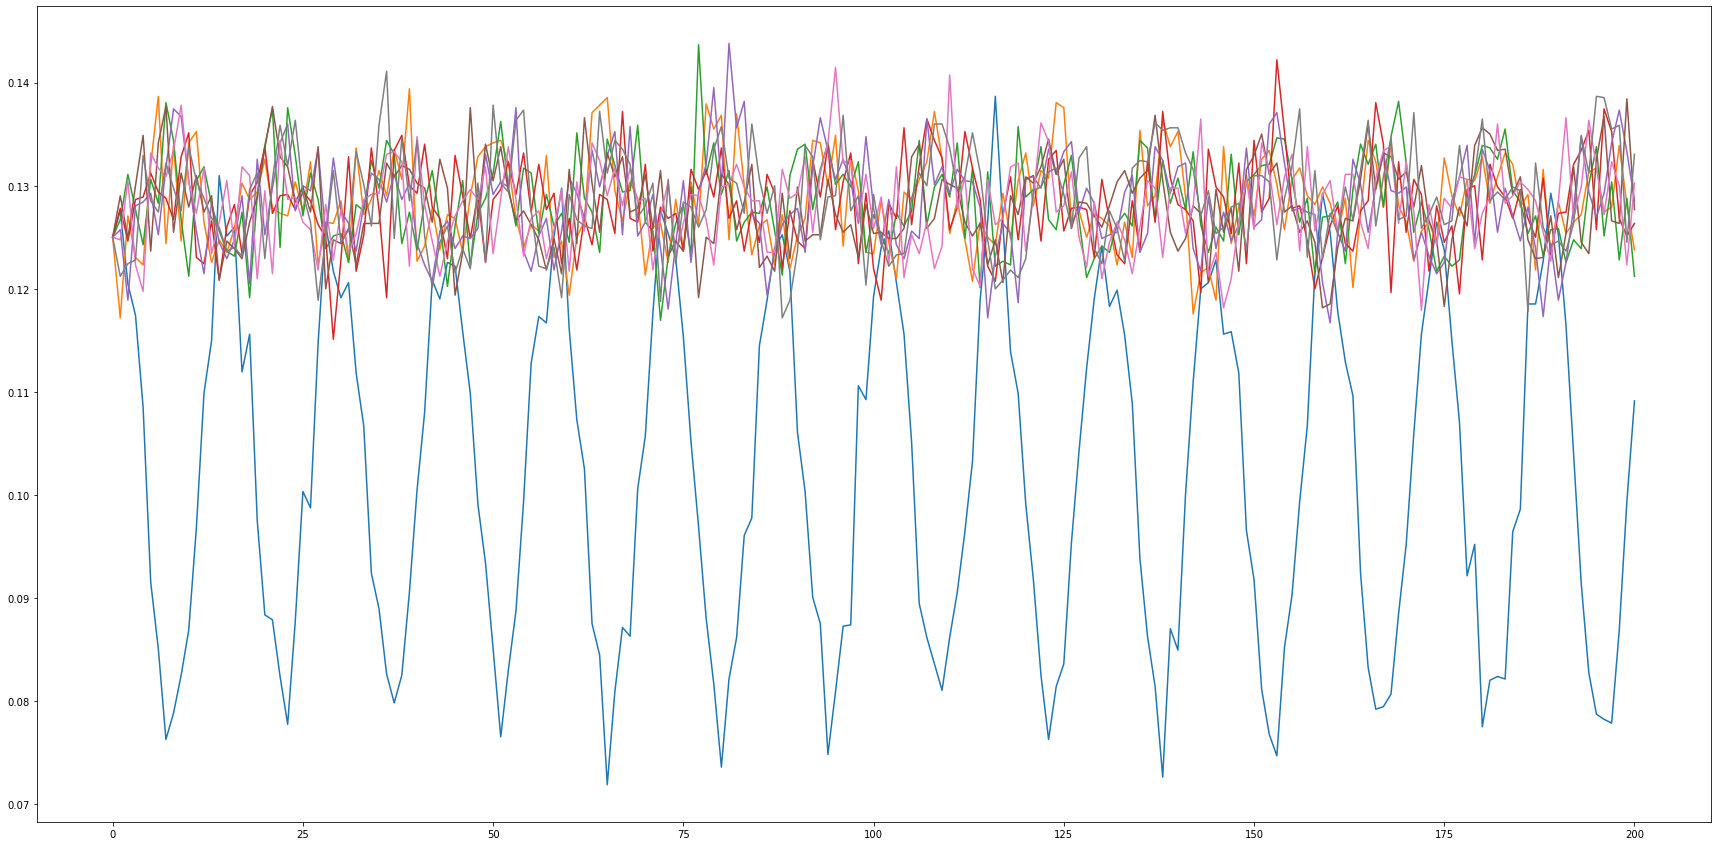

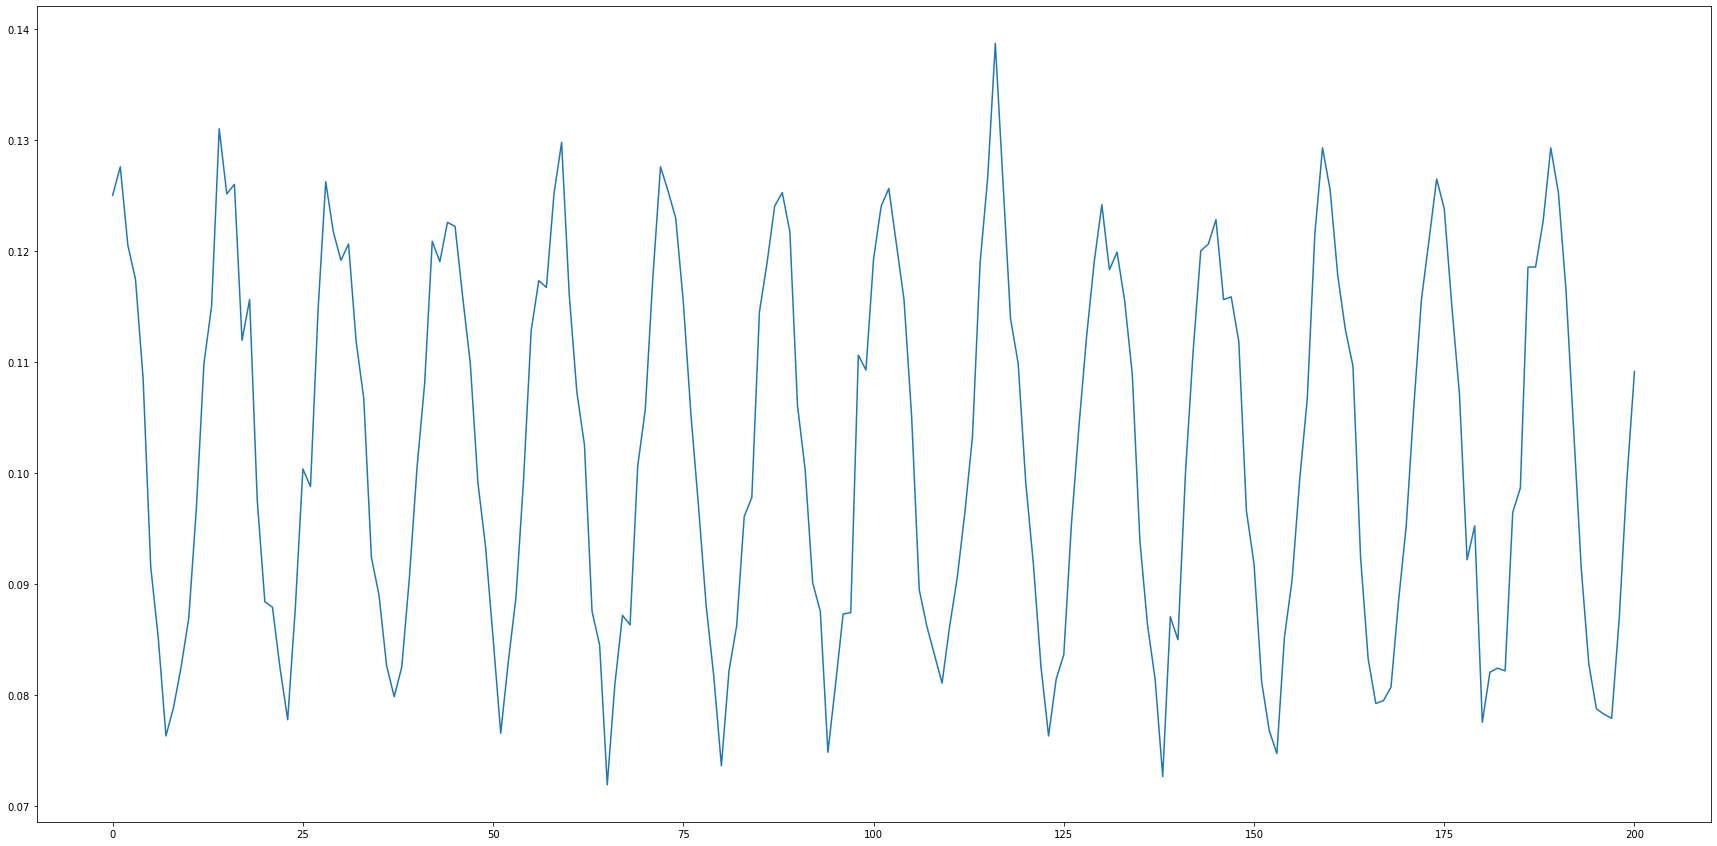

In [34]:
psi = [1/math.sqrt(8) for i in range(8)]
V_diag = [1,0,0,0,0,0,0,0]
data = complete(3,psi,1,0.05,1/math.sqrt(2),V_diag,200,1024*8)
for i in range(8):
    plt.figure(1)
    plt.plot(data[i])
plt.figure(2)
plt.plot(data[0])

In [ ]:
N = [1024,1024*2,1024*4,1024*8]
stddev = []
trials = 10

for j in range(4):
    data = []
    for i in range(trials):
    data.append(complete(3,psi,1,0.1,1/math.sqrt(2),V_diag,100,N[j],'red')[0])
    stddev.append(np.std(data,axis=0))
for i in range(4):
    plt.figure(3)
    plt.plot(stddev[i],label='N='+str(N[i]))
plt.legend()
plt.show()


# **Exact Solution (Complete Graph)**



$i\frac{d\psi}{dt}=(-\gamma L+V-gK)\psi$

In [21]:
from scipy.integrate import solve_ivp
from scipy.integrate import complex_ode

def deriv(t,psi,gamma,numQubits,V,g):
    L = np.zeros(V.shape)
    for i in range(len(L)):
        for j in range(len(L)):
            L[i][j] = -(2**numQubits-1) if i==j else 1
    K = np.copy(V)
    for i in range(len(K)):
        K[i][i] = psi[i]**2
    psidot = np.matmul((-gamma*L + V - g*K)*(-1j), psi)
    psidot.tolist()
    return psidot

def exact_complete(numQubits, psi_init, gamma, V_diag, g, n):
    V = np.zeros((len(V_diag),len(V_diag)))
    for i in range(len(V_diag)):
        V[i][i] = V_diag[i]

    p = (gamma,numQubits,V,g)
    t0,tf = 0, n

    psi = tuple([complex(psi_init[i]) for i in range(len(psi_init))])
    soln = solve_ivp(deriv,(t0,tf),psi,args=p,max_step = 0.005)
    
    for j in range(len(soln.y)):
        for i in range(len(soln.y[j])):
            soln.y[j][i] = np.absolute(soln.y[j][i])**2
    
    return soln.t,soln.y

In [26]:
def compare(T,delta_t,N):
    psi = [1/math.sqrt(8) for i in range(8)]
    V_diag = [1,0,0,0,0,0,0,0]
    exact_data = exact_complete(3,psi,1,V_diag,1,T)
    #sim_data = complete(3,psi,1,delta_t,1/math.sqrt(2),V_diag,n,1024*8) #(num_qubits, psi, g, delta_t, delta_x, V_diag, n, N)

    n = int(T/delta_t)

    data = np.zeros((N,n+1))

    for i in range(N):
        data[i] = complete(3,psi,1,delta_t,1/math.sqrt(2),V_diag,n,1024*8)[0]
        #data = np.append(data, complete(3,psi,1,delta_t,1/math.sqrt(2),V_diag,n,1024*8)[0])
    #data = data.reshape((N, -1))
    mu_hat, stdev_hat = np.mean(data,axis=0), np.std(data, axis=0)
    plt.plot(np.linspace(0,len(exact_data[1][0])-1,n+1),mu_hat)
    plt.plot(exact_data[1][0])
    plt.legend(['simulation','exact'])

]///$\Delta t=0.1, M=1024*8$

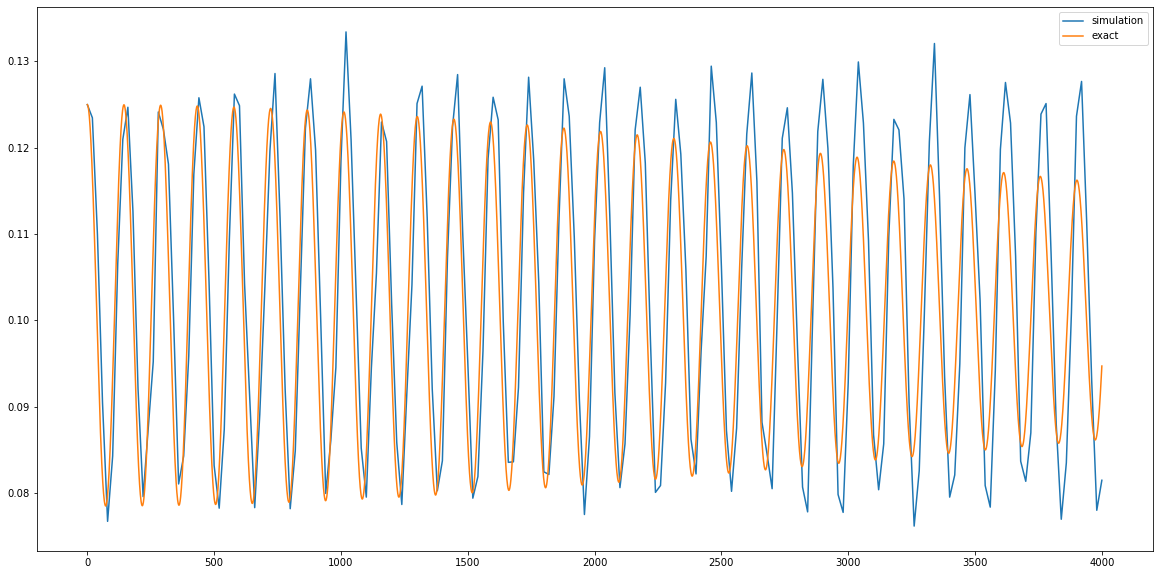

In [27]:
compare(20,0.1,2)

#print(complete(3,[1/math.sqrt(8) for i in range(8)],1,0.1,1/math.sqrt(2),[1,0,0,0,0,0,0,0],int(10/0.1),1024*8)[0])

In [ ]:

plt.plot(np.array(abs(mu_hat - exact_prob[::10]) / (stdev_hat / np.sqrt(N))))